In [1]:
import time
time.ctime()

'Mon Sep 18 20:08:12 2023'

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import importlib as il
import glob
import itertools as it
import random
import warnings
import collections

from scipy import optimize
import ipydex


%load_ext ipydex.displaytools
%matplotlib inline

In [3]:
img_dir = "/home/ck/iee-ge/XAI-DIA/image_classification/stage2/single_bars/raw/"
img_path_list = glob.glob(f"{img_dir}/*.jpg")
img_path_list.sort()

img_fpath = img_path_list[0] ##:

img_fpath := '/home/ck/iee-ge/XAI-DIA/image_classification/stage2/single_bars/raw/2023-06-26_06-22-47_C50.jpg'

---

In [195]:
import stage_2a_bar_selection as bs
il.reload(bs)
from stage_2a_bar_selection import (
    load_img,
    rgb,
    get_bbox_list,
    assign_row_col,
    index_combinations,
    find_missing_boxes,
    handle_missing_boxes,
    select_bar_from_file,
    get_raw_cell,
    get_angle,
    correct_angle,
    rotate_img,
)

vv = {"vmin": 0, "vmax": 255}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

CPU times: user 73.3 ms, sys: 3.99 ms, total: 77.3 ms
Wall time: 63.8 ms


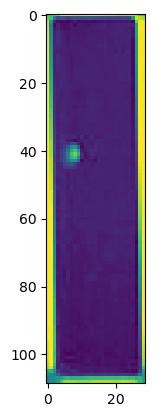

In [10]:
%%time

# extra pixels
ex, ey = 2, 2
ccia = bs.CavityCarrierImageAnalyzier(img_fpath)
img = ccia.get_raw_cell("c", "8", ey, ex, plot=True)

info(cell) := "<class 'numpy.ndarray'> with shape: (104, 23)"

---

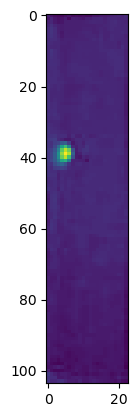

In [11]:
cell = ccia.get_corrected_cell("c", "8") ##:i
plt.imshow(cell)

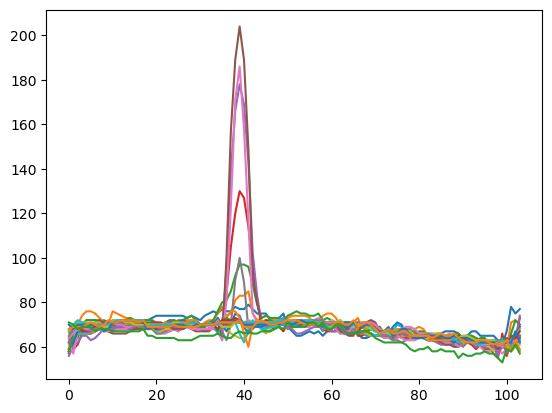

In [12]:
_ = plt.plot(cell)

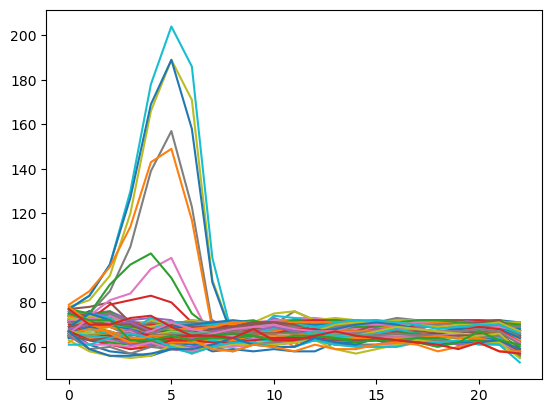

In [13]:
plt.plot(cell.T)
pass

In [14]:
np.histogram(cell, bins=[0, 55, 75, 255])

(array([   1, 2306,   85]), array([  0,  55,  75, 255]))

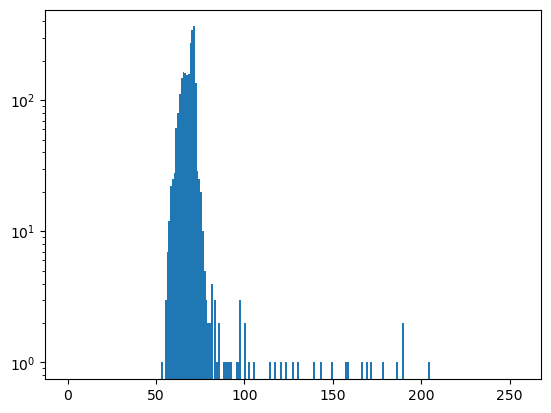

In [15]:
xx = cell# [3:-3, 3:-3]*1
hist, bins, bars = plt.hist(xx.flatten(), bins=np.arange(256), log=True)

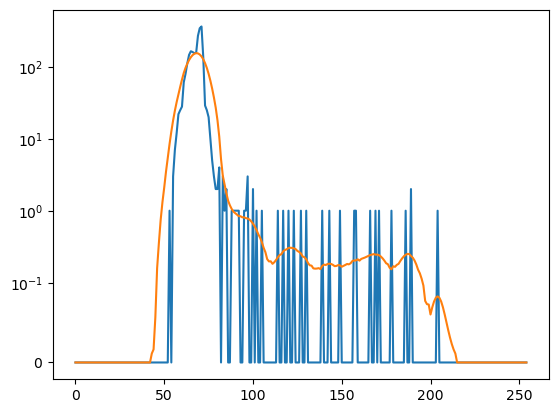

In [16]:
ii = np.arange(255)

def gaussian_kernel(size, sigma):
    x = np.arange(-(size // 2), size // 2 + 1)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel / np.sum(kernel)

def gaussian_smooth(data, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = np.convolve(data, kernel, mode='same')
    return smoothed

hist2 = gaussian_smooth(hist, 20, sigma=5)



plt.plot(ii, hist)
plt.plot(ii, hist2)

plt.yscale('symlog', linthresh=0.1)

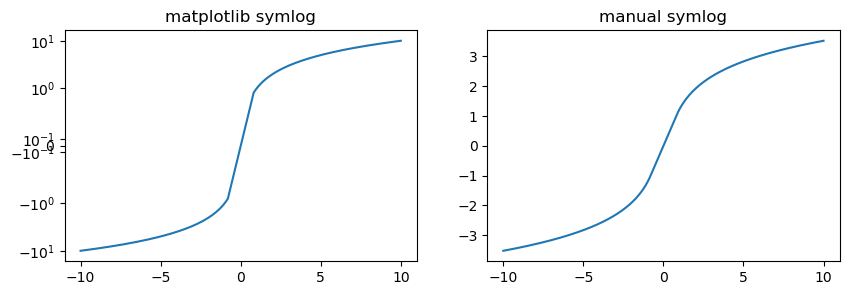

In [17]:
def symlog_transform(x, linthresh):
    eps = 1e-8  # correction for places where x is near 0
    # this prevents warnings, but changes nothing for the value (as long as linthresh > eps)
    
    
    return np.where(
        np.abs(x) > linthresh,
        np.sign(x) * np.log(np.abs(x)/linthresh + eps*(np.abs(x)/linthresh < eps)) + np.sign(x),
        x/linthresh
    )


xx = np.linspace(-10, 10, 1000)
ls = 0.8

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3));

plt.sca(ax1)
plt.plot(xx, xx)
plt.yscale('symlog', linthresh=ls)
plt.title("matplotlib symlog")

plt.sca(ax2)
plt.title("manual symlog")
yy = symlog_transform(xx, linthresh=ls)
plt.plot(xx, yy)


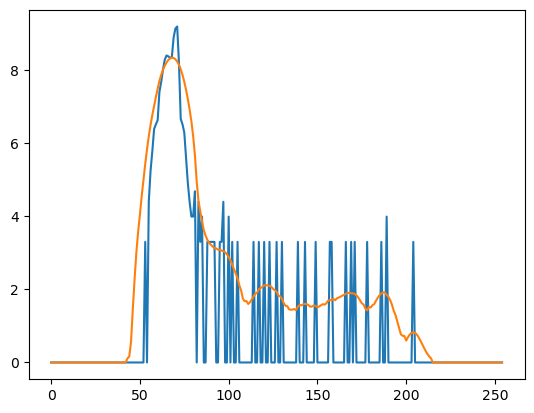

In [18]:
plt.plot(ii, symlog_transform(hist, linthresh=0.1))
plt.plot(ii, symlog_transform(hist2, linthresh=0.1))

# plt.yscale('symlog', linthresh=0.1)

In [19]:
ii = np.arange(255)

def gaussian_kernel(size, sigma):
    x = np.arange(-(size // 2), size // 2 + 1)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel / np.sum(kernel)

def gaussian_smooth(data, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = np.convolve(data, kernel, mode='same')
    return smoothed

def symlog_transform(x, linthresh):
    eps = 1e-8  # correction for places where x is near 0
    # this prevents warnings, but changes nothing for the value (as long as linthresh > eps)
    
    
    return np.where(
        np.abs(x) > linthresh,
        np.sign(x) * np.log(np.abs(x)/linthresh + eps*(np.abs(x)/linthresh < eps)) + np.sign(x),
        x/linthresh
    )


def get_symlog_hist(img_fpath, hr_row, hr_col, ex1=2, ey1=2, ex2=3, ey2=3):
    """
    
    """
    
    ccia = bs.CavityCarrierImageAnalyzier(img_fpath)
    cell = ccia.get_corrected_cell(hr_row, hr_col)

    data = cell.flatten()
    
    
    hist = np.histogram(data, bins=np.arange(256))[0]
    hist2 = gaussian_smooth(hist, 20, sigma=5)
    
    sl_hist1 = symlog_transform(hist, linthresh=0.1)
    sl_hist2 = symlog_transform(hist2, linthresh=0.1)
    
    return sl_hist1, sl_hist2
    

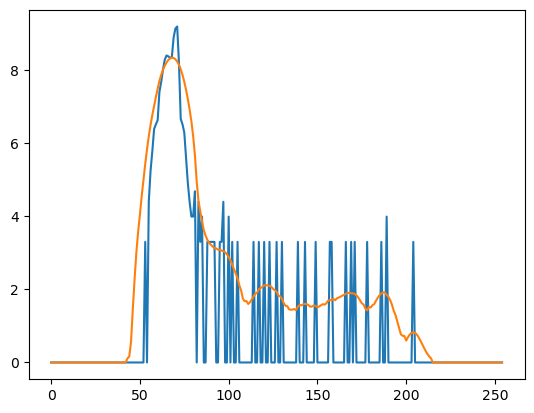

In [20]:
h1, h2 = get_symlog_hist(img_fpath, *"c 8".split())

ii = np.arange(255)
plt.plot(ii, h1)
plt.plot(ii, h2)

In [21]:
# /home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0


img_dir = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0"
img_path_list = glob.glob(f"{img_dir}/*.jpg")
img_path_list.sort()

# omit C100 images

img_path_list2 = []
C100_list = []
for img_fpath in img_path_list:
    # find out if C100 with same base name is in list
    first_parts = img_fpath.split("_")[:-1]
    checkpath = f"{'_'.join(first_parts)}_C100.jpg"
    if checkpath in img_path_list:
        C100_list.append(img_fpath)
    else:
        img_path_list2.append(img_fpath)

img_path_list = img_path_list2

img_fpath = img_path_list[0] ##:

img_fpath := '/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-17-41_C50.jpg'

---

In [22]:
img_path_list ##:i

info((img_path_list)) := "<class 'list'> with length: 827"

---

---

---

**Note**: This only for testing. The actual processing is done in `stage_2b_bar_C0_hist_dict.py`.

---

---

In [111]:
%%time
il.reload(bs)
cell_tups = list(it.product("abc", np.array(range(1, 28), dtype=str)))

hist_cache = collections.defaultdict(list)
bad_cells = collections.defaultdict(list)

for i, img_fpath in enumerate(img_path_list[:1]):
    print(i, img_fpath)
    for cell_tup in cell_tups:
        # print("".join(cell_tup), end="; ")
        try:
            hist_raw, hist_smooth = bs.get_symlog_hist(img_fpath, *cell_tup)
        except RuntimeError:
            bad_cells[img_fpath].append(cell_tup)
        hist_cache[cell_tup].append(hist_smooth)
        
        # break
    # break
        

0 /home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-17-41_C50.jpg
CPU times: user 1.24 s, sys: 64.7 ms, total: 1.31 s
Wall time: 1.57 s


In [107]:
# just preemptive debugging

import dill

q = dill.dumps(hist_cache)

len(q)/1e6

7.579151

**debugging code**

In [181]:
il.reload(bs)

tmp_path = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-19-25_C50.jpg"


ccia = bs.CavityCarrierImageAnalyzier(tmp_path, bboxes=True)

added cell a3
added cell a9
added cell a11
added cell a19
added cell a23
added cell a25
added cell c9
added cell c10
added cell a4
added cell a8
added cell a20
added cell a22
added cell a5
added cell a7
added cell a21
added cell a6


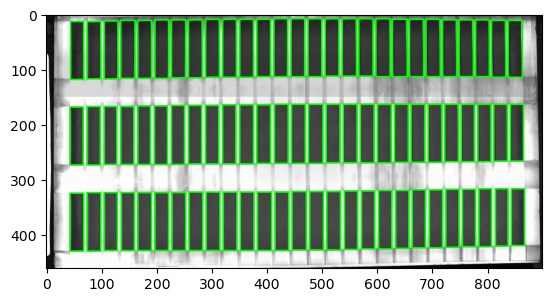

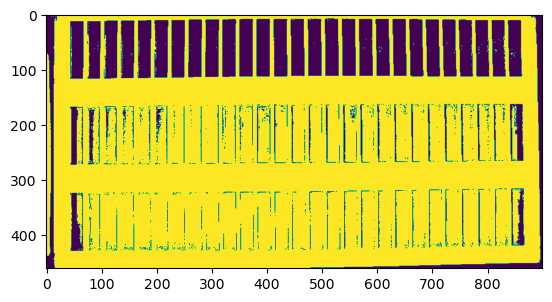

In [189]:
il.reload(bs)
# tmp_path = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-18-31_C50.jpg"
#tmp_path = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-19-58_C50.jpg"

tmp_path = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-19-25_C50.jpg"


ccia = bs.CavityCarrierImageAnalyzier(tmp_path, bboxes=True)

# ccia.show()
dc = bs.Container()
bs.get_bbox_list(ccia.img_lght2, plot=True, dc=dc)

plt.figure()

_, tmp = cv2.threshold(dc.gray, thresh=61, maxval=255, type=cv2.THRESH_BINARY)

plt.imshow(tmp)

if 0:
    rcell = ccia.get_raw_cell("c", "9", plot=False)
    cell = ccia.get_corrected_cell("c", "9", cut_to_bb=False)

    
    
    plt.imshow(rcell)
    plt.figure()
    plt.imshow(cell)

In [200]:
# bs.get_symlog_hist(tmp_path, *"a 20".split(), dc=None)


il.reload(bs)
ccia = bs.CavityCarrierImageAnalyzier(tmp_path, bboxes=True)
cell = ccia.get_corrected_cell("a", "20", cut_to_bb=True, plot=False)

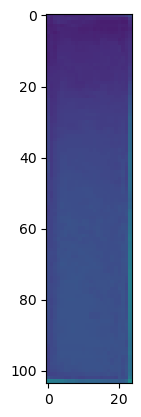

In [201]:
plt.imshow(cell, **vv)